In [18]:
import random
import time
import warnings
from datetime import datetime

import torch
import os

import numpy as np
import warnings
np.warnings = warnings
import matplotlib.pyplot as plt
from tabpfn_new.scripts.differentiable_pfn_evaluation import eval_model_range
from tabpfn_new.scripts.model_builder import get_model, get_default_spec, save_model, load_model
from tabpfn_new.scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, load_model_workflow

from tabpfn_new.scripts.model_configs import *

#from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from tabpfn_new.priors.utils import plot_prior, plot_features
from tabpfn_new.priors.utils import uniform_int_sampler_f

from tabpfn_new.scripts.tabular_metrics import calculate_score_per_method, calculate_score
from tabpfn_new.scripts.tabular_evaluation import evaluate

from tabpfn_new.priors.differentiable_prior import DifferentiableHyperparameterList, draw_random_style, merge_style_with_info
from tabpfn_new.scripts import tabular_metrics
from tabpfn.notebook_utils import *
from tabpfn_new.train import Losses

In [30]:
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
model, config = load_model(path, filename, device="cpu", eval_positions=None, verbose=0)

Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters


In [13]:
config["epoch_frac"] = 0.75
config["multiclass_type"] = "variable_balance"
dl = get_model(config, device="cpu", should_train=False, verbose=0)[3]

Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters


In [29]:
import sklearn
device = "cpu"
possese = []
accs = []
steps = 1000
lr = 0.001
weight_decay = 1
optimizer = torch.optim.AdamW(model[2].parameters(), lr=lr, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()
for i in range(steps):
    #print(f"\n\n\nRun #{i}")
    src, targets, pos = next(iter(dl))
    possese.append(pos)
    targets = targets[pos:]
    output = model[2](src, single_eval_pos=pos)
    loss = criterion(output.reshape(-1, 2), targets.to(device).long().flatten())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    preds = torch.argmax(output, dim=-1).float()
    accuracy =  torch.mean((preds==targets)[targets!=-100].float())
    accs.append(accuracy)
m,b = np.polyfit(possese, accs, 1)
line = np.arange(0,1001,1)*m+b
plt.plot(line)
plt.scatter(possese, accs)

poly_features = sklearn.preprocessing.PolynomialFeatures(degree=3) # decide the maximal degree of the polynomial feature
X_ploy = poly_features.fit_transform(np.array(possese).reshape(-1,1))
lin_reg = sklearn.linear_model.LinearRegression()
lin_reg.fit(X_ploy,accs)
X_new = np.sort(possese,axis = 0) # in order to plot the line of the model, we need to sort the the value of x-axis
X_new_ploy = poly_features.fit_transform(X_new.reshape(-1,1)) # compute the polynomial features 
y_predict = lin_reg.predict(X_new_ploy)
plt.plot(X_new, y_predict)

KeyboardInterrupt: 

In [10]:
def plot_class_dist_bars(bin_avgs):
    step = 1/len(bin_avgs)
    bins = torch.arange(step,1+step,step)
    plt.bar(bins-step, bin_avgs, width=step, align="edge", color="red")
    plt.bar(bins-step, bins-step/2, width=step, align="edge", color="blue", alpha=0.5)
    plt.xlabel = "test"
    plt.show()

In [11]:
def get_binned_class_avg(model, steps=0.025):
    bins = torch.arange(step,1+step,step)
    bin_preds = [[]for _ in bins]
    for i in range(10000):
        src, targets, pos = next(iter(dl))
        targets = targets[pos:]
        output = model[2](src, single_eval_pos=pos)
        preds = torch.argmax(output, dim=-1).float()
        avg_tgt = torch.mean(targets)
        avg_pred = torch.mean(preds)
        bin_num = torch.min(torch.nonzero(bins>=avg_tgt)).item()
        bin_preds[bin_num].append(avg_pred)
    bin_avgs = [torch.nanmean(torch.tensor(b)) for b in bin_preds]

tensor([0.0250, 0.0500, 0.0750, 0.1000, 0.1250, 0.1500, 0.1750, 0.2000, 0.2250,
        0.2500, 0.2750, 0.3000, 0.3250, 0.3500, 0.3750, 0.4000, 0.4250, 0.4500,
        0.4750, 0.5000, 0.5250, 0.5500, 0.5750, 0.6000, 0.6250, 0.6500, 0.6750,
        0.7000, 0.7250, 0.7500, 0.7750, 0.8000, 0.8250, 0.8500, 0.8750, 0.9000,
        0.9250, 0.9500, 0.9750, 1.0000])
[tensor(0.0003), tensor(0.0008), tensor(0.0025), tensor(0.0066), tensor(0.0161), tensor(0.0314), tensor(0.0521), tensor(0.0783), tensor(0.1111), tensor(0.1451), tensor(0.1849), tensor(0.2170), tensor(0.2646), tensor(0.3060), tensor(0.3457), tensor(0.3757), tensor(0.4117), tensor(0.4394), tensor(0.4636), tensor(0.4886), tensor(0.5120), tensor(0.5325), tensor(0.5542), tensor(0.5765), tensor(0.5956), tensor(0.6224), tensor(0.6443), tensor(0.6661), tensor(0.6912), tensor(0.7168), tensor(0.7398), tensor(0.7608), tensor(0.7796), tensor(0.7997), tensor(0.8186), tensor(0.8320), tensor(0.8514), tensor(0.8679), tensor(0.8747), tensor(0.8802)

<BarContainer object of 40 artists>

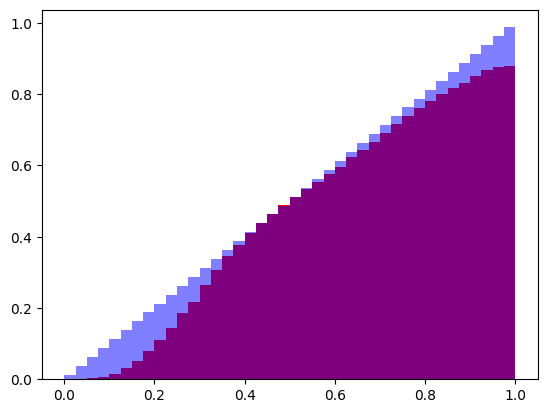

In [31]:
step = 0.025
bins = torch.arange(step,1+step,step)
print(bins)
bin_preds = [[]for _ in bins]
for i in range(10000):
    #print(f"\n\n\nRun #{i}")
    src, targets, pos = next(iter(dl))
    #print(targets.shape)
    #pos = 800
    #print(src[1].sh=step
    targets = targets[pos:]
    output = model[2](src, single_eval_pos=pos)
    preds = torch.argmax(output, dim=-1).float()
    avg_tgt = torch.mean(targets)
    avg_pred = torch.mean(preds)
    #print(avg_tgt)
    bin_num = torch.min(torch.nonzero(bins>=avg_tgt)).item()
    bin_preds[bin_num].append(avg_pred)
    #accuracy = torch.mean((preds==targets)[targets!=-100].float())
bin_avgs = [torch.nanmean(torch.tensor(b)) for b in bin_preds]
print(bin_avgs)
plt.bar(bins-step, bin_avgs, width=step, align="edge", color="red")
plt.bar(bins-step, bins-step/2, width=step, align="edge", color="blue", alpha=0.5)

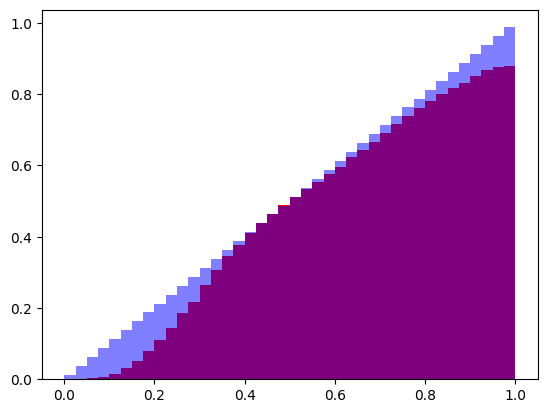

In [32]:
plot_class_dist_bars(bin_avgs)

In [2]:
import os
def load_train_results(name):
    dir_path = os.path.abspath(os.getcwd())
    path = dir_path + f"/logs/trainrun_{name}"
    try:
        losses = torch.load(path+"/losses", weights_only=False)
    except:
        losses = np.array([0])
    mb_results = torch.load(path+"/mb_results", weights_only=False)
    try:
        accuracies = torch.load(path+"/accuracies", weights_only=False)
    except:
        accuracies = np.array([0])
    try:
        class_preds = torch.load(path+"/class_preds", weights_only=False)
    except:
        class_preds = np.array([0])
    return losses, mb_results, accuracies, class_preds

In [3]:
def moving_average(arr, window_size=5):
    if window_size <= 0:
        raise ValueError("Window size must be positive")
    if len(arr) < window_size:
        raise ValueError("Array length must be greater than or equal to the window size")
    
    moving_averages = []
    for i in range(len(arr) - window_size + 1):
        window = arr[i:i + window_size]
        window_avg = sum(window) / window_size
        moving_averages.append(window_avg)
    
    return moving_averages

In [6]:
def plot_metrics(losses, results, accuracies, class_pred, metrics, name):
    fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(5,10))
    for ii, m in enumerate(metrics):
        ax[0].plot(moving_average(results[:,ii], window_size=5), label=m)
    ax[0].grid()
    ax[0].set_ylabel("score")
    ax[0].set_title(name)
    ax[0].legend(loc="upper left")
    ax[1].grid()
    ax[1].plot(moving_average(losses))
    ax[1].set_ylabel("loss")
    ax[2].grid()
    ax[2].plot(moving_average(accuracies))
    ax[2].set_ylabel("train accuracy")
    ax[3].grid()
    ax[3].plot(class_preds)
    plt.xlabel("epoch")
    ax[3].set_ylabel("class balance measure in prediction")
    plt.show()

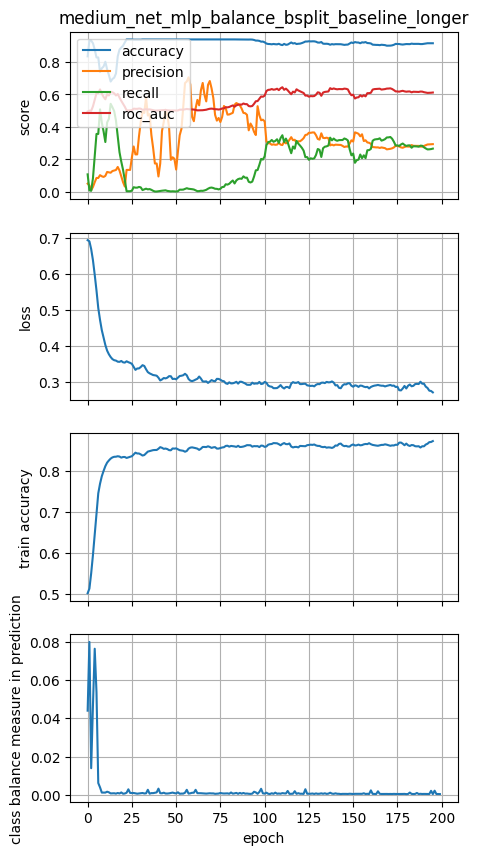

In [7]:
name = "small_net_mlp_variable_balance_weight"#
name = "small_net_mlp_balance_minevalup"#config["run_name"]
#name = "small_net_mlp_varbalance_weight_batchunisplit"
name = "small_net_mlp_varbalance_sqrt_weight_batchunisplit"
name = "medium_net_mlp_balance_bsplit_baseline"
name = "medium_net_mlp_balance_bsplit_baseline_longer"
metrics = ["accuracy", "precision", "recall", "roc_auc"]
losses, mb_results, accuracies, class_preds = load_train_results(name)
plot_metrics(losses, mb_results, accuracies, class_preds, metrics, name)